In [1]:
from models import Generator , Discriminator , weights_init , sampler_noise , show_imgs
import torch
import torchvision.transforms as T
import h5py
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader , Dataset
import torch.optim as optim

%matplotlib inline

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

BATCH_SIZE = 256
NOISE_DIM = 96

All images verified successfully!


In [3]:
def count_para(model):
    total_para = 0
    for para in model.parameters():
        total_para += np.prod(para.size())
    return total_para

In [4]:
class ImageDataset(Dataset):
    
    def __init__(self):
        with h5py.File("animeface-data.hdf5" , "r") as f:
            self.animefaces = np.transpose(np.array(f.get("animefaces")) , (0 , 3 , 1 , 2))
            self.animefaces = torch.tensor(self.animefaces , dtype = torch.float64).type(dtype)
            
    def __len__(self):
        return self.animefaces.size(0)
    
    def __getitem__(self , idx):
        return self.animefaces[idx]   

In [5]:
animefaces = ImageDataset()

In [6]:
animefaces[0].shape

torch.Size([3, 64, 64])

In [7]:
len(animefaces)

21551

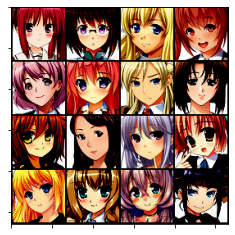

In [8]:
show_imgs(animefaces[0:16].cpu())

In [9]:
loader_train = DataLoader(animefaces , batch_size=256 , shuffle=True)

In [10]:
G = Generator(96 , 64 , 3 , extra_layers=1).type(dtype)
D = Discriminator(3).type(dtype)

In [11]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real , logits_fake):
    N = logits_real.size(0)
    loss = (bce_loss(logits_real , torch.ones(N).type(dtype)) + bce_loss(logits_fake , torch.zeros(N).type(dtype)))
    return loss.mean()

def generator_loss(logits_fake):
    N = logits_fake.size(0)
    loss = bce_loss(logits_fake , torch.ones(N).type(dtype))
    return loss.mean()

In [12]:
count_para(G) , count_para(D)

(3580928, 2765568)

In [13]:
def tran_GAN(D , G , D_optim , G_optim , D_loss , G_loss , show_every = 250 , n_epoch = 10 , save_wt = 100):
    
    iter_cnt = 0
    for epoch in range(n_epoch):
        for X in loader_train:
            if len(X) != BATCH_SIZE:
                continue
            D_optim.zero_grad()
            real_data = X.type(dtype)
            logits_real = D(2*(real_data - 0.5)).type(dtype)
            
            g_fake_seed = sampler_noise(BATCH_SIZE , NOISE_DIM).type(dtype)
            fake_imgs = G(g_fake_seed).detach()
            logits_fake = D(fake_imgs.view(BATCH_SIZE , 3 , 64 , 64))
            
            D_err = D_loss(logits_real , logits_fake)
            D_err.backward()
            D_optim.step()
            
            G_optim.zero_grad()
            g_fake_seed = sampler_noise(BATCH_SIZE, NOISE_DIM).type(dtype)
            fake_images = G(g_fake_seed)
            
            gen_logits_fake = D(fake_images.view(BATCH_SIZE , 3 , 64 , 64))
            G_err = G_loss(gen_logits_fake)
            G_err.backward()
            G_optim.step()
                
            if iter_cnt % show_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4} , T:{:.4}'.format(iter_cnt,D_err.item(),G_err.item() , D_err.item() + G_err.item()))
                imgs = fake_images.data.cpu()
                imgs = imgs.view(BATCH_SIZE , 3 , 64 , 64)
                show_imgs(imgs[0:16] , save_name="./train_imgs/iter{}.png".format(iter_cnt))
                print()
                
            if iter_cnt % save_wt == 0 and iter_cnt >= 2000:
                torch.save(G.state_dict() , "./weights/G{}.pt".format(iter_cnt))
                torch.save(D.state_dict() , "./weights/D{}.pt".format(iter_cnt))
            iter_cnt += 1
            

Iter: 0, D: 1.48, G:2.666 , T:4.146


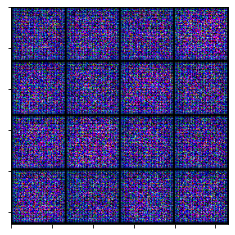


Iter: 250, D: 1.38, G:0.9598 , T:2.34


<Figure size 432x288 with 0 Axes>

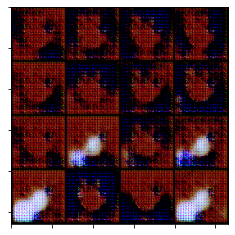


Iter: 500, D: 1.447, G:0.9443 , T:2.392


<Figure size 432x288 with 0 Axes>

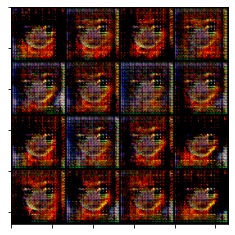


Iter: 750, D: 1.439, G:1.388 , T:2.827


<Figure size 432x288 with 0 Axes>

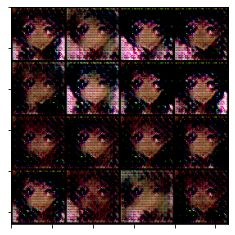


Iter: 1000, D: 1.527, G:1.206 , T:2.733


<Figure size 432x288 with 0 Axes>

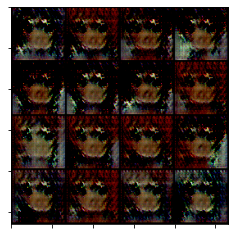


Iter: 1250, D: 1.075, G:0.9184 , T:1.994


<Figure size 432x288 with 0 Axes>

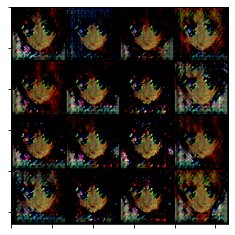


Iter: 1500, D: 1.236, G:1.107 , T:2.343


<Figure size 432x288 with 0 Axes>

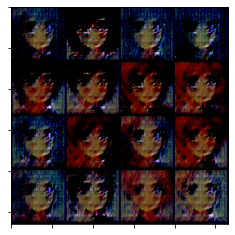


Iter: 1750, D: 1.402, G:1.403 , T:2.806


<Figure size 432x288 with 0 Axes>

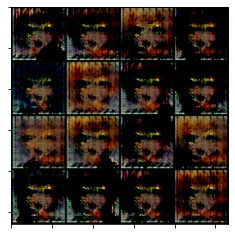


Iter: 2000, D: 2.104, G:2.733 , T:4.837


<Figure size 432x288 with 0 Axes>

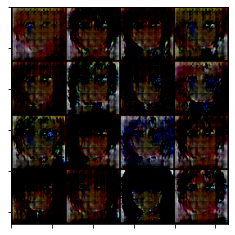


Iter: 2250, D: 1.27, G:1.011 , T:2.281


<Figure size 432x288 with 0 Axes>

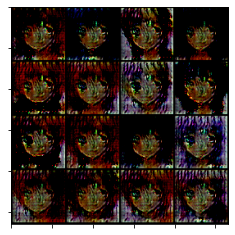


Iter: 2500, D: 1.023, G:1.161 , T:2.183


<Figure size 432x288 with 0 Axes>

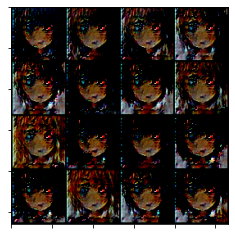


Iter: 2750, D: 1.322, G:1.661 , T:2.983


<Figure size 432x288 with 0 Axes>

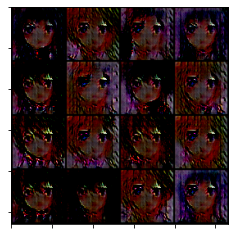


Iter: 3000, D: 1.172, G:1.051 , T:2.223


<Figure size 432x288 with 0 Axes>

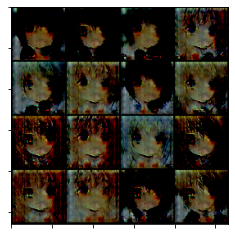


Iter: 3250, D: 1.427, G:0.9593 , T:2.386


<Figure size 432x288 with 0 Axes>

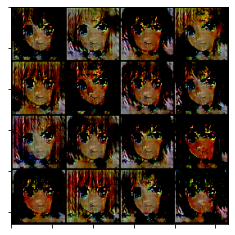


Iter: 3500, D: 1.233, G:3.201 , T:4.434


<Figure size 432x288 with 0 Axes>

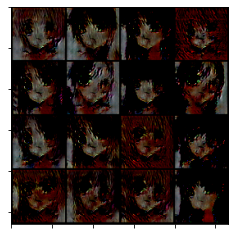


Iter: 3750, D: 1.046, G:1.186 , T:2.232


<Figure size 432x288 with 0 Axes>

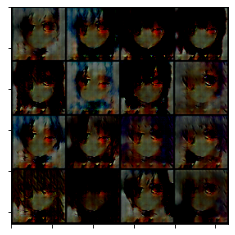


Iter: 4000, D: 1.289, G:0.8657 , T:2.154


<Figure size 432x288 with 0 Axes>

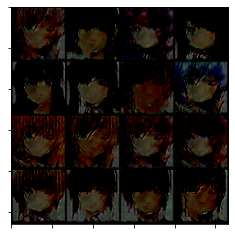


Iter: 4250, D: 0.8064, G:1.783 , T:2.59


<Figure size 432x288 with 0 Axes>

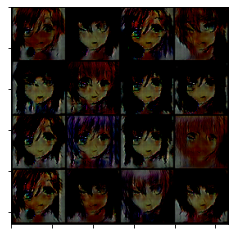


Iter: 4500, D: 1.98, G:2.294 , T:4.274


<Figure size 432x288 with 0 Axes>

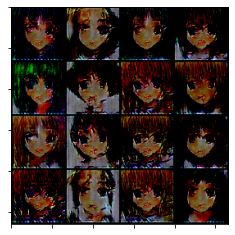


Iter: 4750, D: 0.6994, G:1.378 , T:2.078


<Figure size 432x288 with 0 Axes>

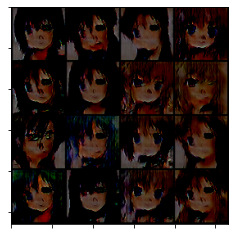


Iter: 5000, D: 0.831, G:1.457 , T:2.288


<Figure size 432x288 with 0 Axes>

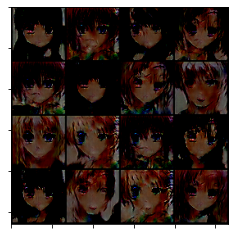


Iter: 5250, D: 1.173, G:2.632 , T:3.804


<Figure size 432x288 with 0 Axes>

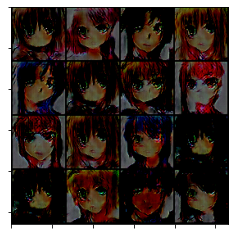


Iter: 5500, D: 1.832, G:3.416 , T:5.248


<Figure size 432x288 with 0 Axes>

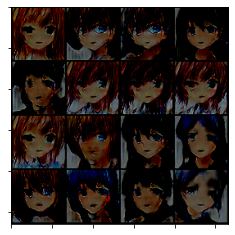


Iter: 5750, D: 0.7915, G:2.107 , T:2.899


<Figure size 432x288 with 0 Axes>

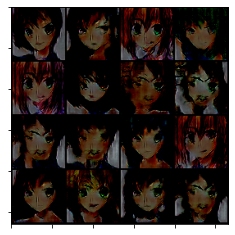


Iter: 6000, D: 0.7334, G:1.519 , T:2.253


<Figure size 432x288 with 0 Axes>

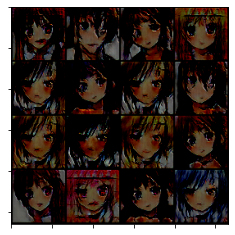


Iter: 6250, D: 2.095, G:3.679 , T:5.774


<Figure size 432x288 with 0 Axes>

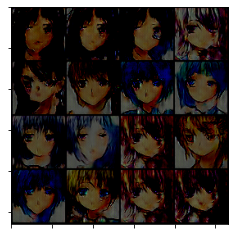


Iter: 6500, D: 0.671, G:1.955 , T:2.626


<Figure size 432x288 with 0 Axes>

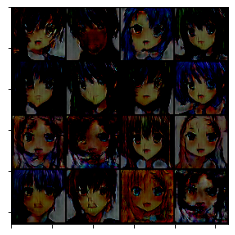


Iter: 6750, D: 0.699, G:1.401 , T:2.1


<Figure size 432x288 with 0 Axes>

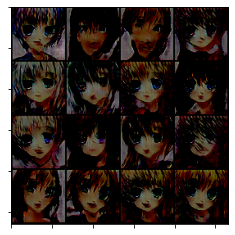


Iter: 7000, D: 2.852, G:4.985 , T:7.837


<Figure size 432x288 with 0 Axes>

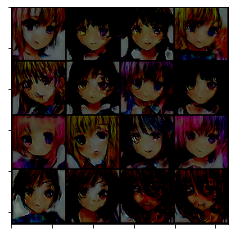


Iter: 7250, D: 0.9158, G:1.273 , T:2.189


<Figure size 432x288 with 0 Axes>

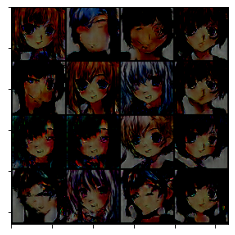


Iter: 7500, D: 0.8493, G:2.812 , T:3.661


<Figure size 432x288 with 0 Axes>

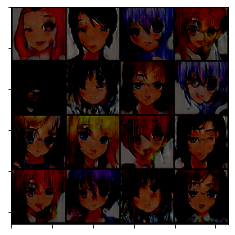


Iter: 7750, D: 0.5942, G:1.636 , T:2.23


<Figure size 432x288 with 0 Axes>

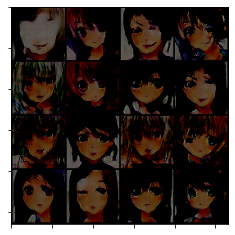


Iter: 8000, D: 0.5312, G:1.783 , T:2.315


<Figure size 432x288 with 0 Axes>

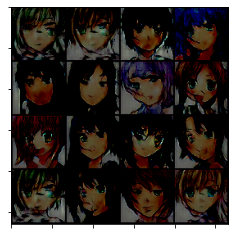


Iter: 8250, D: 1.263, G:1.145 , T:2.407


<Figure size 432x288 with 0 Axes>

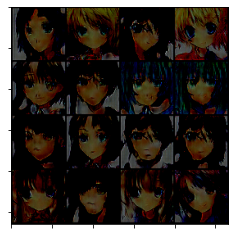

<Figure size 432x288 with 0 Axes>

In [14]:
G_optim = optim.Adam(G.parameters() , lr=1e-3 , betas=(0.5,0.999))
D_optim = optim.Adam(D.parameters() , lr=1e-3 , betas=(0.5,0.999))
tran_GAN(D , G , D_optim , G_optim , discriminator_loss , generator_loss , show_every = 250 , n_epoch = 100)

In [15]:
torch.save(G.state_dict() , "finalG.pt")
torch.save(D.state_dict() , "finalD.pt")